# MPS using the deesse wrapper - simulations with geometrical transformations

## Main points addressed:
- deesse simulation with rotation and/or scaling: local or global / with or without tolerance (uncertainty)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

# import from package 'geone'
import geone.img as img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi

## 1. Global transformation - fixed values (without tolerance)

### Training image (TI)
Read the training image.

In [2]:
ti = img.readImageGslib('ti.gslib')

Plot the image (using the function `imgplt.drawImage2D`).

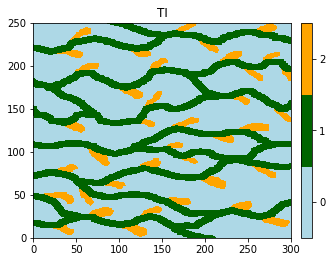

In [3]:
col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, categ=True, categCol=col, title='TI')
plt.show()

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [4]:
nx, ny, nz = 400, 300, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Fill the input structure for deesse and launch deesse
Specify homothety (scaling) and rotation.

**Note:** in presence of both transformations the structures obtained in output are the structures of the TI that have been *rescaled* first and then *rotated*.

In [5]:
nreal = 1
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    homothetyUsage=1,           # use homothety (scaling) without tolerance
    homothetyXLocal=False,      #    along x: global homothety
    homothetyXRatio=1.33,       #    along x: value for scaling factor
    homothetyYLocal=False,      #    along y: global homothety
    homothetyYRatio=0.75,       #    along y: value for scaling factor
    rotationUsage=1,            # use rotation without tolerance
    rotationAzimuthLocal=False, #    rotation according to azimuth: global
    rotationAzimuth=20.,        #    rotation azimuth: value
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210609 / OpenMP 7 thread(s)]
Deesse run complete


### Retrieve the results (and display)

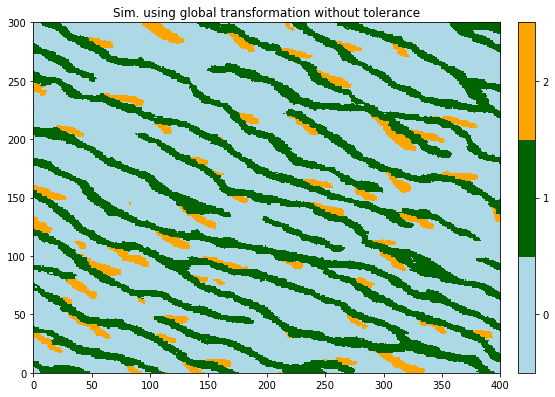

In [6]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
imgplt.drawImage2D(sim[0], categ=True, categCol=col,
                   title='Sim. using global transformation without tolerance')
plt.show()

## 2. Global transformations - with tolerance

One can specify a range of value for the geometrical transformations.

In [7]:
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    homothetyUsage=2,           # use homothety (scaling) with tolerance
    homothetyXLocal=False,      #    along x: global homothety
    homothetyXRatio=[0.5, 2.],  #    along x: min and max values for scaling factor
    homothetyYLocal=False,      #    along y: global homothety
    homothetyYRatio=[0.5, 2.],  #    along y: min and max values for scaling factor
    rotationUsage=2,            # use rotation with tolerance
    rotationAzimuthLocal=False, #    rotation according to azimuth: global
    rotationAzimuth=[0., 180.], #    rotation azimuth: min and max values
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210609 / OpenMP 7 thread(s)]
Deesse run complete


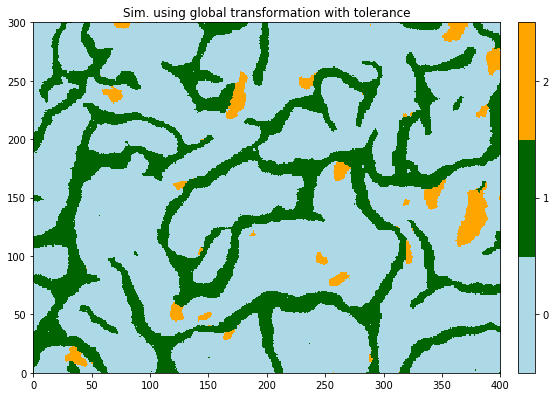

In [8]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
imgplt.drawImage2D(sim[0], categ=True, categCol=col,
                   title='Sim. using global transformation with tolerance')
plt.show()

## 3. Local transformations - fixed values (without tolerance)

### Build a map for homothety ratio and azimuth angle
Below, a piece of python code to build:

- `scaling`: (`nz`, `ny`, `nx`)-array containing homothety ratio values on the simulation grid
- `angle`: (`nz`, `ny`, `nx`)-array containing angle values on the simulation grid

In [9]:
center_x, center_y = 250, 150
scaling_start, scaling_end = 1., 0.5

t = 180./np.pi

angle = []
scaling = []
k = 0
y = -center_y
for j in range(ny):
    x = -center_x
    for i in range(nx):
        angle.append(-math.atan2(y,x) * t)
        scaling.append(math.sqrt(x*x+y*y))
        x = x + 1.0
    y = y + 1.0

angle = np.asarray(angle).reshape(nz, ny, nx)

scaling_min = np.min(scaling)
scaling_max = np.max(scaling)
t = 1./(scaling_max - scaling_min) * (scaling_end - scaling_start)
scaling = scaling_start + (scaling - scaling_min) * t
scaling = np.asarray(scaling).reshape(nz, ny, nx)

### Display homothety ratio map and azimuth map

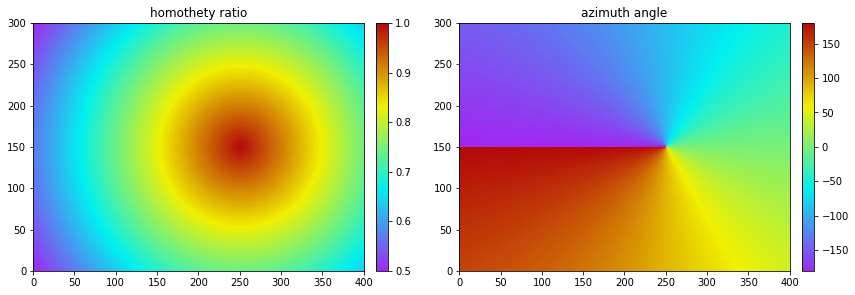

In [10]:
# Define images ('img.Img' class)
im_scaling = img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=scaling)
im_angle = img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=angle)

# Display
plt.subplots(1,2, figsize=(14,7)) # 1 x 2 sub-plots

plt.subplot(1,2,1)
imgplt.drawImage2D(im_scaling, title='homothety ratio')

plt.subplot(1,2,2)
imgplt.drawImage2D(im_angle, title='azimuth angle')

plt.show()

### Fill the input structure for deesse and launch deesse

In [11]:
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    homothetyUsage=1,           # use homothety (scaling) without tolerance
    homothetyXLocal=True,       #    along x: local homothety
    homothetyXRatio=scaling,    #    along x: map of values for scaling factor
    homothetyYLocal=True,       #    along y: local homothety
    homothetyYRatio=scaling,    #    along y: map of values for scaling factor
    rotationUsage=1,            # use rotation without tolerance
    rotationAzimuthLocal=True,  #    rotation according to azimuth: local
    rotationAzimuth=angle,      #    rotation azimuth: map of values
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210609 / OpenMP 7 thread(s)]
Deesse run complete


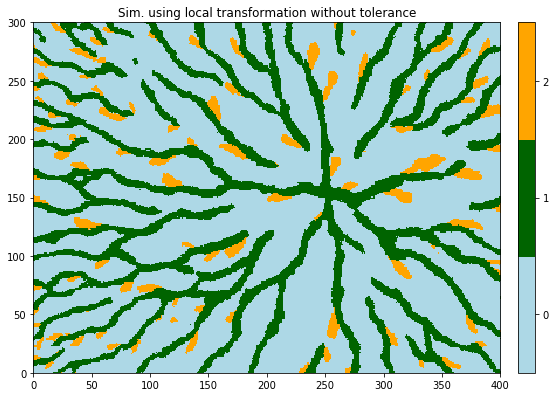

In [12]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
imgplt.drawImage2D(sim[0], categ=True, categCol=col,
                   title='Sim. using local transformation without tolerance')
plt.show()

## 4. Local transformations - with tolerance

The minimal and maximal values (range) for the considered transformation must be given at each cell of the simulation grid.
- `scaling_min_max`: (2, `nz`, `ny`, `nx`)-array containing homothety min and max ratio values on the simulation grid
- `angle_min_max`: (2, `nz`, `ny`, `nx`)-array containing min and max angle values on the simulation grid

In [13]:
scaling_tol = 0.3
scaling_min_max = np.array((scaling-scaling_tol, scaling+scaling_tol))

angle_tol = 45.
angle_min_max = np.array((angle-angle_tol, angle+angle_tol))

deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    homothetyUsage=2,                # use homothety (scaling) with tolerance
    homothetyXLocal=True,            #    along x: local homothety
    homothetyXRatio=scaling_min_max, #    along x: map of min and max values for scaling factor
    homothetyYLocal=True,            #    along y: local homothety
    homothetyYRatio=scaling_min_max, #    along y: map of min and max values for scaling factor
    rotationUsage=2,                 # use rotation with tolerance
    rotationAzimuthLocal=True,       #    rotation according to azimuth: local
    rotationAzimuth=angle_min_max,   #    rotation azimuth: map of min and max values
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20210609 / OpenMP 7 thread(s)]
Deesse run complete


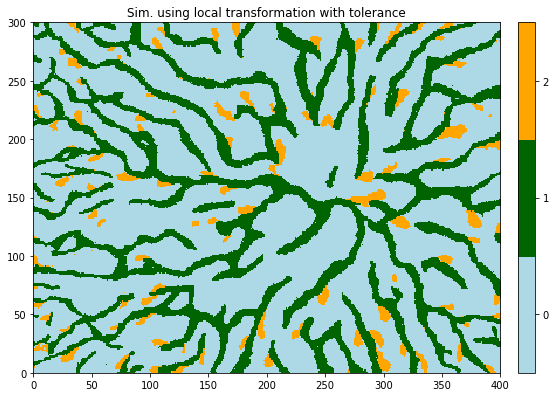

In [14]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
imgplt.drawImage2D(sim[0], categ=True, categCol=col,
                   title='Sim. using local transformation with tolerance')
plt.show()